MNIST CNN

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.vision import *

DATA

In [4]:
path = untar_data(URLs.MNIST)

In [5]:
path.ls()

[PosixPath('/root/.fastai/data/mnist_png/training'),
 PosixPath('/root/.fastai/data/mnist_png/testing')]

In [6]:
#as it is black and so convert_mode = L
il = ImageList.from_folder(path, convert_mode='L')

In [7]:
il.items[0]

PosixPath('/root/.fastai/data/mnist_png/training/4/34611.png')

In [8]:
defaults.cmap='binary'

In [9]:
il

ImageList (70000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /root/.fastai/data/mnist_png

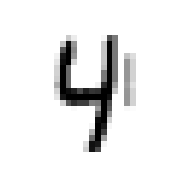

In [10]:
il[0].show()

In [11]:
sd = il.split_by_folder(train='training', valid='testing')

In [12]:
sd

ItemLists;

Train: ImageList (60000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /root/.fastai/data/mnist_png;

Valid: ImageList (10000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /root/.fastai/data/mnist_png;

Test: None

In [13]:
(path/'training').ls()

[PosixPath('/root/.fastai/data/mnist_png/training/4'),
 PosixPath('/root/.fastai/data/mnist_png/training/0'),
 PosixPath('/root/.fastai/data/mnist_png/training/6'),
 PosixPath('/root/.fastai/data/mnist_png/training/2'),
 PosixPath('/root/.fastai/data/mnist_png/training/7'),
 PosixPath('/root/.fastai/data/mnist_png/training/5'),
 PosixPath('/root/.fastai/data/mnist_png/training/9'),
 PosixPath('/root/.fastai/data/mnist_png/training/1'),
 PosixPath('/root/.fastai/data/mnist_png/training/8'),
 PosixPath('/root/.fastai/data/mnist_png/training/3')]

In [14]:
#label it
ll = sd.label_from_folder()

In [15]:
ll

LabelLists;

Train: LabelList (60000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
4,4,4,4,4
Path: /root/.fastai/data/mnist_png;

Valid: LabelList (10000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
4,4,4,4,4
Path: /root/.fastai/data/mnist_png;

Test: None

In [16]:
x,y = ll.train[0]

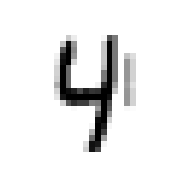

In [17]:
x.show()

In [18]:
print(y,x.shape)

4 torch.Size([1, 28, 28])


In [19]:
#Adding transforms,no transofrom for validation
tfms = ([*rand_pad(padding=3, size=28, mode='zeros')], [])

In [20]:
ll = ll.transform(tfms)

In [21]:
bs = 128


In [22]:
# not using imagenet_stats because not using pretrained model
data = ll.databunch(bs=bs).normalize()


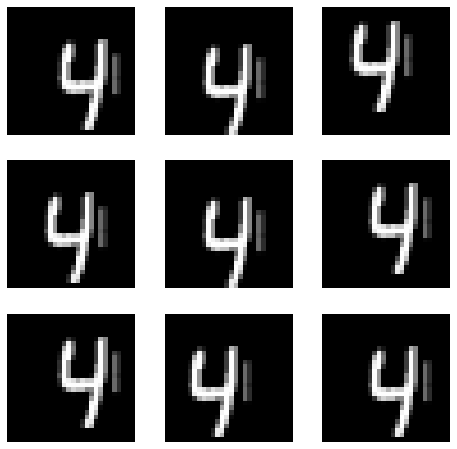

In [23]:
def _plot(i,j,ax): data.train_ds[0][0].show(ax, cmap='gray')
plot_multi(_plot, 3, 3, figsize=(8,8))

In [24]:
xb,yb = data.one_batch()
xb.shape,yb.shape


(torch.Size([128, 1, 28, 28]), torch.Size([128]))

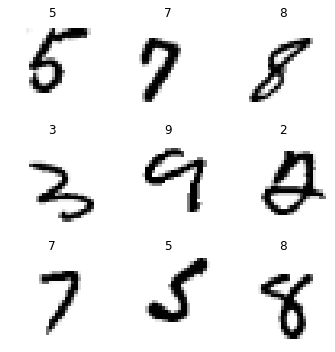

In [25]:
data.show_batch(rows=3, figsize=(5,5))

Basic CNN with batchnorm

In [68]:
#writing function to apply models again and again
def conv(ni,nf):
   return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)

In [69]:
model = nn.Sequential(    
    conv(1, 8), # 14           #you always get to pick how many filters so in this case it is 8 and stride is 2 so 28 by 28 image is now 14 by 14 so specifically it is an (8,14,14)
    nn.BatchNorm2d(8),
    nn.ReLU(),
    conv(8, 16), # 7
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 32), # 4
    nn.BatchNorm2d(32),
    nn.ReLU(),
    conv(32, 16), # 2
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 10), # 1        #we get (10,1,1) which is a vector
    nn.BatchNorm2d(10),
    Flatten()     # remove (1,1) grid and it is vector of 10
)

In [70]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [71]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          80         True      
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
Conv2d               [16, 7, 7]           1,168      True      
______________________________________________________________________
BatchNorm2d          [16, 7, 7]           32         True      
______________________________________________________________________
ReLU                 [16, 7, 7]           0          False     
______________________________________________________________________
Conv2d               [32, 4, 4]           4,640      True      
___________________________________________________

In [72]:
xb =xb.cuda()

In [73]:
#confirming if it is okay
model(xb).shape

torch.Size([128, 10])

In [74]:
learn.lr_find(end_lr=100)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


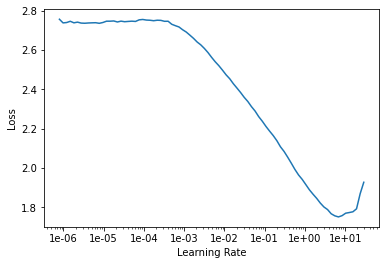

In [76]:
learn.recorder.plot()

In [77]:
learn.fit_one_cycle(3, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.224803,0.866286,0.777600,00:26
1,0.129152,0.085718,0.972900,00:25
2,0.071450,0.039445,0.987600,00:26


Refactor

In [30]:
#rather than calling conv,batch norm,relu fast ai already has conv_layer that does same thing
def conv2(ni,nf): 
  return conv_layer(ni,nf,stride=2)

In [79]:
model = nn.Sequential(
    conv2(1, 8),   # 14
    conv2(8, 16),  # 7
    conv2(16, 32), # 4
    conv2(32, 16), # 2
    conv2(16, 10), # 1
    Flatten()      # remove (1,1) grid
)

In [81]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [82]:
learn.fit_one_cycle(3, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.237002,0.201624,0.937900,00:25
1,0.138175,0.071250,0.977300,00:25
2,0.069214,0.037876,0.987700,00:25


Resnet-ish

In [27]:
class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf,nf)
        self.conv2 = conv_layer(nf,nf)
        
    def forward(self, x): return x + self.conv2(self.conv1(x))

In [28]:
help(res_block)

Help on function res_block in module fastai.layers:

res_block(nf, dense:bool=False, norm_type:Union[fastai.layers.NormType, NoneType]=<NormType.Batch: 1>, bottle:bool=False, **conv_kwargs)
    Resnet block of `nf` features. `conv_kwargs` are passed to `conv_layer`.



In [31]:
#applying resblock
model = nn.Sequential(
    conv2(1, 8),
    res_block(8),
    conv2(8, 16),
    res_block(16),
    conv2(16, 32),
    res_block(32),
    conv2(32, 16),
    res_block(16),
    conv2(16, 10),
    Flatten()
)

In [32]:
#since we are using so many conv2 and res_block so make it applicable easy everytime we can define as one
def conv_and_res(ni,nf): 
  return nn.Sequential(conv2(ni, nf), res_block(nf))

In [33]:
model = nn.Sequential(
    conv_and_res(1, 8),
    conv_and_res(8, 16),
    conv_and_res(16, 32),
    conv_and_res(32, 16),
    conv2(16, 10),
    Flatten()
)

In [34]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


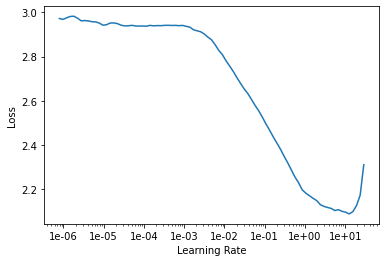

In [35]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [37]:
learn.fit_one_cycle(12, max_lr=0.05)

epoch,train_loss,valid_loss,accuracy,time
0,0.051259,0.037826,0.988500,00:30
1,0.072524,0.074968,0.977300,00:30
2,0.090936,0.096969,0.971600,00:29
3,0.080604,0.100025,0.968500,00:30
4,0.058795,0.135617,0.959300,00:30
5,0.058482,0.051358,0.984600,00:30
6,0.046807,0.058837,0.981600,00:30
7,0.042921,0.050219,0.985100,00:30
8,0.032339,0.026560,0.991900,00:30
9,0.025346,0.019835,0.993900,00:30


In [38]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          72         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
___________________________________________________